## 1. Load Data

In [1]:
#load in necessary packages
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sns


In [2]:
df = pd.read_csv('olineman_full2.csv')

In [3]:
df.head()

,displayName,pff_positionLinedUp,x_std,y_std,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,gameId,playId,nflId,team,down,yardsToGo,defensiveTeam,homeOrAway,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,penaltyCommitted,olineman_win,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed
0,Donovan Smith,LT,41.55,26.89,5.545260,1.012640,33,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
1,Donovan Smith,LT,41.54,26.88,5.431814,1.012640,33,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
2,Donovan Smith,LT,41.53,26.89,3.869395,0.991871,33,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
3,Donovan Smith,LT,41.50,26.89,3.013485,0.991871,33,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0
4,Donovan Smith,LT,41.46,26.91,2.924474,0.963247,33,2.253908,53504.0,1.348332,42404.0,4.608188,25511.0,3.021523,87,NaN,2021090900,97,42377.0,TB,3,2,DAL,home,0,0,42403.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0,0,0.0,0.0,1.0,0.0


In [4]:
df = df[df.penaltyCommitted != 1]

In [5]:
pd.options.display.min_rows = 115
df.isnull().sum()
print(df.isna().sum())

displayName                    0
pff_positionLinedUp            0
x_std                          0
y_std                          0
dir_std                        0
o_std                          0
yardLine_std                   0
Opp_Dist                       0
closestOpp_Id                  0
Team_Dist                      0
closestTeam_Id                 0
QB_Dist                        0
closestQB_Id                   0
FootDist                       0
secondsIntoGame                0
secondsIntoPlay                5
gameId                         0
playId                         0
nflId                          0
team                           0
down                           0
yardsToGo                      0
defensiveTeam                  0
homeOrAway                     0
preSnapHomeScore               0
preSnapVisitorScore            0
pff_nflIdBlockedPlayer     44284
offenseFormation            1446
personnelO                   180
defendersInBox              1446
personnelD

In [6]:
#convert nulls to 0 where relevant
df.secondsIntoPlay[df.secondsIntoPlay.isna()] = 0.0
df.defendersInBox = df.defendersInBox[df.defendersInBox.isna()] = 0
df.pff_nflIdBlockedPlayer = df.pff_nflIdBlockedPlayer[df.pff_nflIdBlockedPlayer.isna()] = 0

In [7]:
#remove remaining null columns
df = df.dropna()

## 2. Binary Classifier

In [8]:
# one hot encode categorical variables
X = df.drop(['olineman_win' ,'pff_beatenByDefender',
                  'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed'], axis = 1)
X = X.drop(['team', 'defensiveTeam'], axis = 1)
dummies = pd.get_dummies(X[['pff_positionLinedUp', 'homeOrAway', 'offenseFormation', 'personnelO', 'personnelD', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType']])
X = X.drop(['pff_positionLinedUp', 'homeOrAway', 'offenseFormation', 'personnelO', 'personnelD', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType'], axis = 1)
X = X.join(dummies)
y = df[['olineman_win', 'pff_beatenByDefender',
                   'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]

In [9]:
#drop variables to prevent perfect collinearity and multi-collinearity
X = X.drop(['x_std', 'y_std', 'nflId', 'gameId', 'pff_positionLinedUp_C', 'offenseFormation_JUMBO','personnelO_6 OL, 2 RB, 2 TE, 0 WR', 'personnelD_6 DL, 1 LB, 4 DB', 'homeOrAway_away', 'dropBackType_UNKNOWN', 'pff_passCoverage_Miscellaneous', 'pff_passCoverageType_Other'], axis = 1)

In [10]:
#create df for binary classification and multiclassification
df2 = X.join(y.olineman_win)
y2 = y.drop('olineman_win', axis = 1)
#df4 = X.join(y2)
#df4.to_csv('multiclass.csv', index = False)

### 2.1 Under Sampling

1    1505099
0     178667
Name: olineman_win, dtype: int64


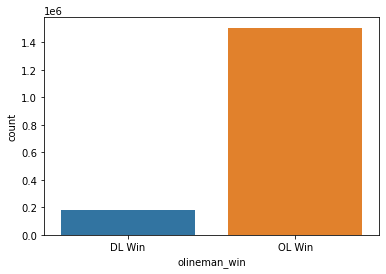

In [11]:
#plot
print(y.olineman_win.value_counts())
class_names = ['DL Win','OL Win']
ax = sns.countplot(x=y.olineman_win); 
ax.set_xticklabels(class_names)
plt.show()

In [12]:
# Divide by class
df_class_0    = df2[df2['olineman_win'] == 0] #class with more samples
df_class_1    = df2[df2['olineman_win'] == 1] #class with fewer samples
count_class_0 = len(df_class_0)
count_class_1 = len(df_class_1)

Random Under-Sampling:
1    178667
0    178667
Name: olineman_win, dtype: int64


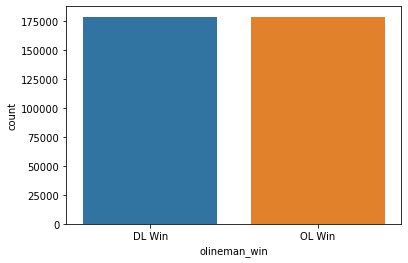

In [13]:
df_class_1_under = df_class_1.sample(count_class_0, replace=True)
df_under         = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random Under-Sampling:')
print(df_under.olineman_win.value_counts())
#plot
ax = sns.countplot(x=df_under['olineman_win']); 
ax.set_xticklabels(class_names)
plt.show()

In [14]:
df_under.head()

,displayName,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,playId,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR",...,"personnelO_7 OL, 1 RB, 0 TE, 2 WR","personnelD_0 DL, 3 LB, 8 DB","personnelD_0 DL, 5 LB, 6 DB","personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,olineman_win
428862,Solomon Kindley,3.410024,5.493424,69,0.680074,39960.0,1.838695,52426.0,2.713116,43380.0,6.317349,2604,2.7,1934,1,10,0,14,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1
647105,Tyre Phillips,2.466325,5.780007,26,1.843177,45226.0,2.190091,41222.0,4.427923,52895.0,4.490401,4288,0.7,3873,1,10,17,41,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1
140804,Tyron Smith,2.095617,6.235014,6,2.391757,43378.0,1.653390,46119.0,4.431365,43424.0,4.465087,2443,0.1,1759,3,10,20,7,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1176572,Royce Newman,1.421396,5.837603,68,1.154340,52605.0,0.759605,53491.0,3.399779,29851.0,3.447028,2415,1.2,1357,1,10,7,14,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
300399,Bobby Hart,2.241352,5.937785,39,2.608237,40051.0,2.167602,35472.0,3.650671,38538.0,4.126257,3203,0.6,2531,1,10,27,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,

In [15]:
X = df_under.drop(['displayName', 'playId','olineman_win'], axis = 1)
y = df_under.olineman_win

Undersample because very large dataset

### 2.2 Random Forest

In [16]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
# param_grid = {
#     "n_estimators": [80, 90, 100],
#     "criterion":("gini", "entropy"), 
#     "min_samples_split":([2,5]),
#     "max_features": ['sqrt', 5],
# }
# #Random forest classifier
# clf = RandomForestClassifier(bootstrap=False,random_state=0)
# tree_cv = GridSearchCV(estimator=clf, param_grid = param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
# tree_cv.fit(X_tr, y_tr)
# best_params = tree_cv.best_params_
# print(f"Best paramters: {best_params})")
# #
# clf = RandomForestClassifier(**best_params,random_state=0)
# clf.fit(X_tr, y_tr)
# y_pred = clf.predict(X_te)
# #
# acc = accuracy_score(y_te, y_pred)
# cm = confusion_matrix(y_te, y_pred)
# #plot
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
# cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
# cmd.plot(ax=axes[0])
# axes[0].set_title('counts')
# cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
# cmd.plot(ax=axes[1])
# axes[1].set_title('normalized')
# fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16); #Best parameters: {{'criterion': 'entropy', 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 100})}

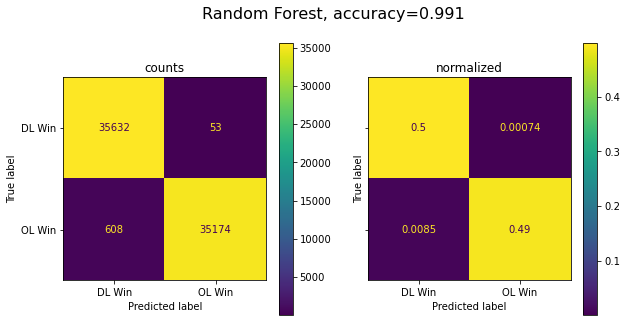

In [19]:
#Random forest classifier
clf = RandomForestClassifier(criterion = 'entropy', max_features = 5, min_samples_split = 2, n_estimators=100 ,random_state=0)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);

In [20]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35685
           1       1.00      0.98      0.99     35782

    accuracy                           0.99     71467
   macro avg       0.99      0.99      0.99     71467
weighted avg       0.99      0.99      0.99     71467



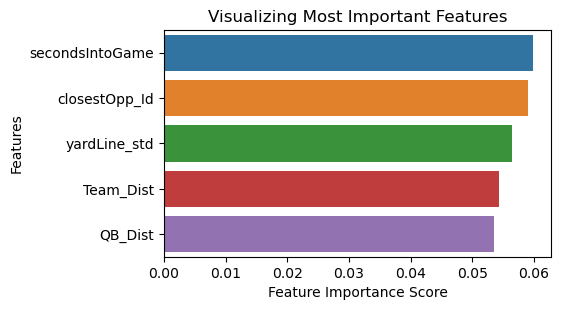

In [21]:
#view feature importance
features = X.columns.tolist()
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False).head(5)
# Creating a bar plot
fig, ax = plt.subplots(figsize=(5, 3),dpi= 100)  #original shape was 8.1, 10
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Most Important Features")
plt.show()

### Apply model to full dataset

In [22]:
df2.head()

,displayName,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,playId,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR",...,"personnelO_7 OL, 1 RB, 0 TE, 2 WR","personnelD_0 DL, 3 LB, 8 DB","personnelD_0 DL, 5 LB, 6 DB","personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,olineman_win
0,Donovan Smith,5.545260,1.012640,33,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87,0.0,97,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,Donovan Smith,5.431814,1.012640,33,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87,0.0,97,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,Donovan Smith,3.869395,0.991871,33,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87,0.0,97,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,Donovan Smith,3.013485,0.991871,33,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87,0.0,97,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,Donovan Smith,2.924474,0.963247,33,2.253908,53504.0,1.348332,42404.0,4.608188,25511.0,3.021523,87,0.0,97,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [23]:
X = df2.drop([ 'displayName','playId', 'olineman_win'], axis = 1)
y = df2.olineman_win

In [24]:
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)

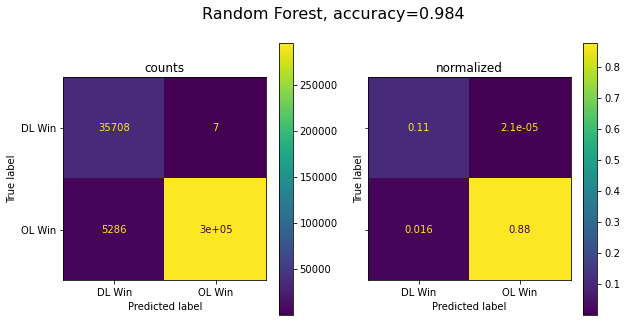

In [25]:
y_pred = clf.predict(X_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names ) 
cmd.plot(ax=axes[0])
axes[0].set_title('counts')
cmd = ConfusionMatrixDisplay(cm/np.sum(cm[:]),display_labels=class_names) 
cmd.plot(ax=axes[1])
axes[1].set_title('normalized')
fig.suptitle('Random Forest, accuracy=%2.3f'%(acc), fontsize=16);

In [26]:
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     35715
           1       1.00      0.98      0.99    301039

    accuracy                           0.98    336754
   macro avg       0.94      0.99      0.96    336754
weighted avg       0.99      0.98      0.98    336754



### Make DF of Predictions and Rank Olinemen

In [39]:
# Make WR win predictions a DF
pred_OLwin = clf.predict(df2.drop([ 'displayName', 'playId', 'olineman_win'], axis = 1))
pred_OLwin = pd.DataFrame(pred_OLwin, columns = ['pred_OLwin'])
df3 = pd.concat([df2, pred_OLwin], axis = 1)
df3.head()

,displayName,dir_std,o_std,yardLine_std,Opp_Dist,closestOpp_Id,Team_Dist,closestTeam_Id,QB_Dist,closestQB_Id,FootDist,secondsIntoGame,secondsIntoPlay,playId,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,pff_nflIdBlockedPlayer,defendersInBox,pff_playAction,penaltyCommitted,pff_positionLinedUp_LG,pff_positionLinedUp_LT,pff_positionLinedUp_RG,pff_positionLinedUp_RT,homeOrAway_home,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT,"personnelO_0 RB, 0 TE, 5 WR","personnelO_0 RB, 1 TE, 4 WR","personnelO_0 RB, 2 TE, 3 WR","personnelO_0 RB, 3 TE, 2 WR","personnelO_1 RB, 0 TE, 4 WR","personnelO_1 RB, 1 TE, 2 WR,1 LB","personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 2 TE, 2 WR","personnelO_1 RB, 3 TE, 1 WR","personnelO_1 RB, 4 TE, 0 WR","personnelO_2 QB, 1 RB, 0 TE, 3 WR","personnelO_2 QB, 1 RB, 1 TE, 2 WR","personnelO_2 QB, 1 RB, 2 TE, 1 WR","personnelO_2 QB, 1 RB, 3 TE, 0 WR","personnelO_2 QB, 2 RB, 0 TE, 2 WR","personnelO_2 QB, 2 RB, 1 TE, 1 WR","personnelO_2 QB, 6 OL, 1 RB, 1 TE, 1 WR",...,"personnelD_0 DL, 3 LB, 8 DB","personnelD_0 DL, 5 LB, 6 DB","personnelD_1 DL, 2 LB, 8 DB","personnelD_1 DL, 3 LB, 7 DB","personnelD_1 DL, 4 LB, 6 DB","personnelD_1 DL, 5 LB, 5 DB","personnelD_2 DL, 2 LB, 7 DB","personnelD_2 DL, 3 LB, 6 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_2 DL, 5 LB, 4 DB","personnelD_3 DL, 1 LB, 7 DB","personnelD_3 DL, 2 LB, 6 DB","personnelD_3 DL, 3 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB","personnelD_3 DL, 5 LB, 3 DB","personnelD_4 DL, 1 LB, 6 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_4 DL, 3 LB, 4 DB","personnelD_4 DL, 4 LB, 3 DB","personnelD_4 DL, 5 LB, 2 DB","personnelD_4 DL, 6 LB, 1 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_5 DL, 2 LB, 4 DB","personnelD_5 DL, 3 LB, 3 DB","personnelD_5 DL, 5 LB, 1 DB","personnelD_6 DL, 2 LB, 3 DB","personnelD_6 DL, 3 LB, 2 DB","personnelD_6 DL, 4 LB, 1 DB",dropBackType_DESIGNED_ROLLOUT_LEFT,dropBackType_DESIGNED_ROLLOUT_RIGHT,dropBackType_DESIGNED_RUN,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Man,pff_passCoverageType_Zone,olineman_win,pred_OLwin
0,Donovan Smith,5.545260,1.012640,33.0,2.151279,53504.0,1.293406,42404.0,4.627883,25511.0,3.162183,87.0,0.0,97.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Donovan Smith,5.431814,1.012640,33.0,2.161227,53504.0,1.287051,42404.0,4.605779,25511.0,3.049098,87.0,0.0,97.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Donovan Smith,3.869395,0.991871,33.0,2.172211,53504.0,1.296534,42404.0,4.591841,25511.0,3.067507,87.0,0.0,97.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Donovan Smith,3.013485,0.991871,33.0,2.211990,53504.0,1.306331,42404.0,4.602445,25511.0,3.059412,87.0,0.0

In [43]:
df3 = df3[['displayName', 'playId', 'pred_OLwin', 'olineman_win', 'pff_positionLinedUp_LT', 'pff_positionLinedUp_LG', 'pff_positionLinedUp_RG', 'pff_positionLinedUp_RT']]

In [44]:
df3.head()

,displayName,playId,pred_OLwin,olineman_win,pff_positionLinedUp_LT,pff_positionLinedUp_LG,pff_positionLinedUp_RG,pff_positionLinedUp_RT
0,Donovan Smith,97.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Donovan Smith,97.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Donovan Smith,97.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Donovan Smith,97.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Donovan Smith,97.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
# top linemen
average_win = df3.groupby(['displayName', 'playId']).mean('pred_OLwin').reset_index()
num_wins = df3.groupby('displayName').sum('pred_OLwin').reset_index()
best_OL = num_wins.sort_values(by = 'pred_OLwin', ascending = False).reset_index(drop = True)
best_OL['WinOverExpected'] = best_OL['olineman_win']-best_OL['pred_OLwin']
best_OL = best_OL.sort_values(by = 'WinOverExpected', ascending = False).reset_index(drop = True)

In [51]:
best_OL.head(5)

,displayName,playId,pred_OLwin,olineman_win,pff_positionLinedUp_LT,pff_positionLinedUp_LG,pff_positionLinedUp_RG,pff_positionLinedUp_RT,WinOverExpected
0,Bobby Massie,24788225.0,5873.0,10422.0,0.0,0.0,0.0,11882.0,4549.0
1,Tristan Wirfs,25568677.0,6805.0,10990.0,0.0,0.0,0.0,11503.0,4185.0
2,Taylor Moton,26066236.0,6327.0,10391.0,1532.0,0.0,0.0,10328.0,4064.0
3,Mike Remmers,10898211.0,0.0,3691.0,0.0,0.0,0.0,4285.0,3691.0
4,Rob Havenstein,18150912.0,5258.0,8910.0,0.0,0.0,0.0,9838.0,3652.0


In [50]:
best_OL.to_csv('best_OL.csv', index = False)